In [18]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
%matplotlib inline

## Data Preparation

In [19]:
acs = pd.read_csv('final_acs_transportation_choice.csv')
acs.head()

,taxi_zone,P(mode1),P(mode2),P(mode3),P(mode4),P(mode5)
0,3.0,0.228957,35.391246,14.547350,7706.507979,949.324468
1,4.0,46.244797,152.049702,91.310873,7487.249289,2840.145340
2,5.0,0.349401,56.498123,9.104389,7989.174863,173.873224
3,6.0,0.263186,18.439186,4.534672,4767.467108,478.295847
4,7.0,29.894066,167.041570,44.019826,33307.536619,3139.507920


In [21]:
mode_data_origin = pd.read_csv('final_allMode_with_wage.csv', index_col=0).set_index('ODpair')
mode_data_origin = mode_data_origin.dropna()
mode_data_origin.head()

,PUlocationID,DOlocationID,duration,price,2500,7500,12500,17500,22500,30000,42500,62500,87500,125000,225000,mode,nest
ODpair,,,,,,,,,,,,,,,,,
3-3,3,3,6.508943,16.647073,11.412271,16.389811,29.504545,12.840609,18.871367,26.936423,30.543336,42.705845,26.705581,33.702991,23.387221,1,1
3-4,3,4,39.695000,64.000000,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.938590,0.586936,0.740725,0.514005,2,1
3-4,3,4,45.216667,61.500000,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.938590,0.586936,0.740725,0.514005,3,1
3-4,3,4,83.000000,5.500000,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.938590,0.586936,0.740725,0.514005,4,2
3-4,3,4,225.933333,0.000000,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.938590,0.586936,0.740725,0.514005,5,3


**Remove same OD-pair**

since there is no data for PT and walking under same OD pair, need to remove the same OD pair for nest1 mode

In [3]:
mode_data_origin.shape

(245274, 17)

In [4]:
mode_data_origin = mode_data_origin[mode_data_origin['PUlocationID'].astype(int) != mode_data_origin['DOlocationID'].astype(int)]
mode_data_origin.head()

,PUlocationID,DOlocationID,duration,price,2500,7500,12500,17500,22500,30000,42500,62500,87500,125000,225000,mode,nest
ODpair,,,,,,,,,,,,,,,,,
3-4,3,4,39.695000,64.000000,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.93859,0.586936,0.740725,0.514005,2,1
3-4,3,4,45.216667,61.500000,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.93859,0.586936,0.740725,0.514005,3,1
3-4,3,4,83.000000,5.500000,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.93859,0.586936,0.740725,0.514005,4,2
3-4,3,4,225.933333,0.000000,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.93859,0.586936,0.740725,0.514005,5,3
3-7,3,7,47.880952,43.157143,1.504915,2.161294,3.890709,1.693267,2.488532,3.552056,4.027693,5.63154,3.521615,4.444350,3.084029,1,1


In [5]:
# Keeping track of number of rows lost (around 250)
mode_data_origin.shape

(245034, 17)

#### Remove outliers

In [6]:
# Only keep positive values of price for nest 1 and 2 and positive values of duration for all nests
mode_data_origin = mode_data_origin[(mode_data_origin['duration']>0) & ((mode_data_origin['price']>0) | (mode_data_origin['nest']==3))]

In [7]:
# Lost about 7 rows..that's acceptable
mode_data_origin.shape

(245027, 17)

In [8]:
# Checking that walking does not have any negative values for price
mode_data_origin[(mode_data_origin.nest==3) & (mode_data_origin.price<0)]

,PUlocationID,DOlocationID,duration,price,2500,7500,12500,17500,22500,30000,42500,62500,87500,125000,225000,mode,nest
ODpair,,,,,,,,,,,,,,,,,


In [9]:
mode_data1 = mode_data_origin[mode_data_origin['nest']==1]
mode_data2 = mode_data_origin[mode_data_origin['nest']==2]
mode_data3 = mode_data_origin[mode_data_origin['nest']==3] 
## Calculating the difference between duration and price normalized by price
mode_data1['diff_price'] = (mode_data1['duration'] - mode_data1['price'])/mode_data1['price']

## Normalizing by duration is also an option but it results in many inliers also being dropped in addition to outliers; so, it is less preferred.

mode_data1['diff_duration'] = (mode_data1['duration'] - mode_data1['price'])/mode_data1.duration


# mode_data2['diff'] = mode_data2['duration'] - mode_data2['price']


def remove_outlier(df, var):
    '''
    Function for removing outliers
    '''
    # find Q1 and Q3 and IQR
    Q1, Q3 = df[var].quantile(0.25), df[var].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5 * IQR, Q3 + 1.5 * IQR
    # find the data within desired range
    df = df[(df[var] >= lower) & (df[var] <= upper)]
    return df

### Option 1: Remove outliers for nest 1 using normalization by price(recommended)

The original shape of nest1 data is (134810, 19)
The minmum difference is -0.9996268656716417
The maximum difference is 4262.333333333333


Text(0.5, 1.0, 'The original nest1 hist of the difference between duration and price')

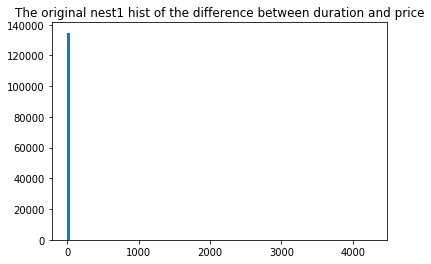

In [10]:
print('The original shape of nest1 data is', mode_data1.shape)
print('The minmum difference is', min(mode_data1['diff_price']))
print('The maximum difference is', max(mode_data1['diff_price']))
plt.hist(mode_data1['diff_price'], bins=100)
plt.title('The original nest1 hist of the difference between duration and price')

In [11]:
mode_data1.shape

(134810, 19)

The cleaned nest1 data shape is (131799, 19)
The minmum difference is -0.8076211757866434
The maximum difference is 0.6612884646120809


,PUlocationID,DOlocationID,duration,price,2500,7500,12500,17500,22500,30000,42500,62500,87500,125000,225000,mode,nest,diff_price,diff_duration
ODpair,,,,,,,,,,,,,,,,,,,
3-4,3,4,39.695000,64.000000,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.93859,0.586936,0.740725,0.514005,2,1,-0.379766,-0.612294
3-4,3,4,45.216667,61.500000,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.93859,0.586936,0.740725,0.514005,3,1,-0.264770,-0.360118
3-7,3,7,47.880952,43.157143,1.504915,2.161294,3.890709,1.693267,2.488532,3.552056,4.027693,5.63154,3.521615,4.444350,3.084029,1,1,0.109456,0.098657
3-7,3,7,30.521739,47.000000,1.504915,2.161294,3.890709,1.693267,2.488532,3.552056,4.027693,5.63154,3.521615,4.444350,3.084029,2,1,-0.350601,-0.539886
3-7,3,7,37.159009,45.000000,1.504915,2.161294,3.890709,1.693267,2.488532,3.552056,4.027693,5.63154,3.521615,4.444350,3.084029,3,1,-0.174244,-0.211012


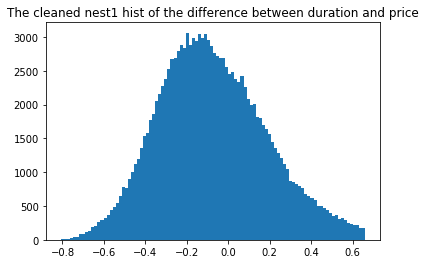

In [12]:
#remove the outliers
mode_data1 = remove_outlier(mode_data1, 'diff_price')

print('The cleaned nest1 data shape is', mode_data1.shape)
plt.hist(mode_data1['diff_price'], bins=100)
plt.title('The cleaned nest1 hist of the difference between duration and price')
print('The minmum difference is', min(mode_data1['diff_price']))
print('The maximum difference is', max(mode_data1['diff_price']))
mode_data1.head()

In [13]:
mode_data1.shape

(131799, 19)

#### Do not run Option 2 if you have ran Option 1

### Option 2: Remove outliers for nest 1 using normalization by duration(not recommended)

The original shape of nest1 data is (134810, 19)
The minmum difference is -2678.9999999999995
The maximum difference is 0.9997654417513683


Text(0.5, 1.0, 'The original nest1 hist of the difference between duration and price')

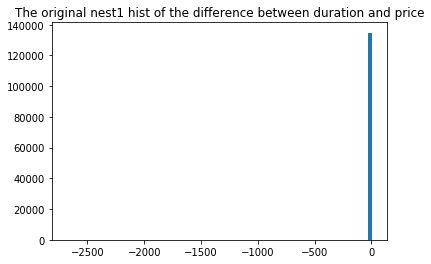

In [109]:
print('The original shape of nest1 data is', mode_data1.shape)
print('The minmum difference is', min(mode_data1['diff_duration']))
print('The maximum difference is', max(mode_data1['diff_duration']))
plt.hist(mode_data1['diff_duration'], bins=100)
plt.title('The original nest1 hist of the difference between duration and price')

In [110]:
mode_data1.shape

(134810, 19)

The cleaned nest1 data shape is (129559, 19)
The minmum difference is -1.0128760164225123
The maximum difference is 0.765711043620465


,PUlocationID,DOlocationID,duration,price,2500,7500,12500,17500,22500,30000,42500,62500,87500,125000,225000,mode,nest,diff_price,diff_duration
ODpair,,,,,,,,,,,,,,,,,,,
3-4,3,4,39.695000,64.000000,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.93859,0.586936,0.740725,0.514005,2,1,-0.379766,-0.612294
3-4,3,4,45.216667,61.500000,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.93859,0.586936,0.740725,0.514005,3,1,-0.264770,-0.360118
3-7,3,7,47.880952,43.157143,1.504915,2.161294,3.890709,1.693267,2.488532,3.552056,4.027693,5.63154,3.521615,4.444350,3.084029,1,1,0.109456,0.098657
3-7,3,7,30.521739,47.000000,1.504915,2.161294,3.890709,1.693267,2.488532,3.552056,4.027693,5.63154,3.521615,4.444350,3.084029,2,1,-0.350601,-0.539886
3-7,3,7,37.159009,45.000000,1.504915,2.161294,3.890709,1.693267,2.488532,3.552056,4.027693,5.63154,3.521615,4.444350,3.084029,3,1,-0.174244,-0.211012


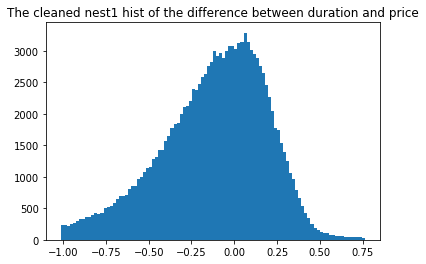

In [111]:
#remove the outliers
mode_data1 = remove_outlier(mode_data1, 'diff_duration')

print('The cleaned nest1 data shape is', mode_data1.shape)
plt.hist(mode_data1['diff_duration'], bins=100)
plt.title('The cleaned nest1 hist of the difference between duration and price')
print('The minmum difference is', min(mode_data1['diff_duration']))
print('The maximum difference is', max(mode_data1['diff_duration']))
mode_data1.head()

In [112]:
# Around 2000 more rows are dropped with this option
mode_data1.shape

(129559, 19)

#### This results in trips like 167-84 (2nd row) being dropped which are actual trips that happened. This particular OD-pair is from the Bronx to Staten Island which is a very costly and long trip distance wise but by taking the FDR drive and other relatively less congested routes, the trip duration is shorter which results in it being classified as an outlier.

In [115]:
mode_data_origin.sort_values('price',ascending=False).head()

,PUlocationID,DOlocationID,duration,price,2500,7500,12500,17500,22500,30000,42500,62500,87500,125000,225000,mode,nest
ODpair,,,,,,,,,,,,,,,,,
28-134,28,134,5.932645,7505.38876,3.333476,4.731385,7.196928,5.886068,6.167698,9.524216,11.254961,16.933646,10.251333,11.792618,8.927672,1,1
167-84,167,84,60.300000,279.00000,0.338284,0.417661,0.469767,0.430160,0.361984,0.591186,0.701566,0.999757,0.760003,1.063875,1.865758,2,1
174-44,174,44,84.000000,272.00000,0.402176,0.604567,0.714319,0.719528,0.497419,0.956146,0.991118,1.398130,0.702042,0.665210,0.349347,2,1
169-214,169,214,70.916667,269.50000,0.118771,0.151128,0.210973,0.135220,0.128077,0.209891,0.261782,0.297387,0.189871,0.184460,0.112440,2,1
174-172,174,172,69.300000,268.50000,0.402176,0.604567,0.714319,0.719528,0.497419,0.956146,0.991118,1.398130,0.702042,0.665210,0.349347,2,1


In [116]:
mode_data1.sort_values('price',ascending=False).head()

,PUlocationID,DOlocationID,duration,price,2500,7500,12500,17500,22500,30000,42500,62500,87500,125000,225000,mode,nest,diff_price,diff_duration
ODpair,,,,,,,,,,,,,,,,,,,
208-68,208,68,196.783333,220.5,5.958727,7.532099,8.488025,7.150845,6.946269,11.197721,13.790250,22.756238,16.909097,24.483971,30.786757,1,1,-0.107559,-0.120522
259-109,259,109,110.516667,192.0,0.148678,0.164235,0.292952,0.191905,0.174422,0.319521,0.545705,0.684058,0.525055,0.537996,0.415474,2,1,-0.424392,-0.737295
254-206,254,206,89.983333,179.0,0.961723,0.870529,1.275047,1.029492,1.038695,1.806735,2.285714,3.001046,1.937252,2.271073,1.522694,3,1,-0.497300,-0.989257
174-210,174,210,108.129545,178.5,1.206529,1.813700,2.142957,2.158583,1.492257,2.868437,2.973353,4.194391,2.106125,1.995629,1.048040,2,1,-0.394232,-0.650798
200-214,200,214,92.933333,175.5,0.326395,0.246996,0.286481,0.396352,0.297854,0.486910,0.727897,0.887768,0.736481,0.826824,0.780043,2,1,-0.470465,-0.888451


### Concating the 3 modes back

In [14]:
# Dropping the features that were engineered specifically for detecting outliers
mode_data1.drop(['diff_price','diff_duration'],axis=1,inplace=True)

In [15]:
mode_data_origin.head()

,PUlocationID,DOlocationID,duration,price,2500,7500,12500,17500,22500,30000,42500,62500,87500,125000,225000,mode,nest
ODpair,,,,,,,,,,,,,,,,,
3-4,3,4,39.695000,64.000000,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.93859,0.586936,0.740725,0.514005,2,1
3-4,3,4,45.216667,61.500000,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.93859,0.586936,0.740725,0.514005,3,1
3-4,3,4,83.000000,5.500000,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.93859,0.586936,0.740725,0.514005,4,2
3-4,3,4,225.933333,0.000000,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.93859,0.586936,0.740725,0.514005,5,3
3-7,3,7,47.880952,43.157143,1.504915,2.161294,3.890709,1.693267,2.488532,3.552056,4.027693,5.63154,3.521615,4.444350,3.084029,1,1


In [16]:
mode_data_origin = pd.concat([mode_data1, mode_data2, mode_data3])
print(mode_data_origin.shape)
mode_data_origin.head()

(242016, 17)


,PUlocationID,DOlocationID,duration,price,2500,7500,12500,17500,22500,30000,42500,62500,87500,125000,225000,mode,nest
ODpair,,,,,,,,,,,,,,,,,
3-4,3,4,39.695000,64.000000,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.93859,0.586936,0.740725,0.514005,2,1
3-4,3,4,45.216667,61.500000,0.250819,0.360216,0.648452,0.282211,0.414755,0.592009,0.671282,0.93859,0.586936,0.740725,0.514005,3,1
3-7,3,7,47.880952,43.157143,1.504915,2.161294,3.890709,1.693267,2.488532,3.552056,4.027693,5.63154,3.521615,4.444350,3.084029,1,1
3-7,3,7,30.521739,47.000000,1.504915,2.161294,3.890709,1.693267,2.488532,3.552056,4.027693,5.63154,3.521615,4.444350,3.084029,2,1
3-7,3,7,37.159009,45.000000,1.504915,2.161294,3.890709,1.693267,2.488532,3.552056,4.027693,5.63154,3.521615,4.444350,3.084029,3,1


In [53]:
mode_data_origin.to_csv('final_allMode_with_wage_cleaned.csv')